#**Capstone project: Can ML Outperform Market-Neutral Trading in Structural Breaks?**

**Note:**

It's a good practise to "restart the session", whenever changes are made to the github repository


##**Step 1:** GitHub setup

1) Clone/Update the projects github repository

In [ ]:
# Use for the first time to clone the github repo or when the repo is updated
%rm -rf /content/MarketNeutral_Trading/
%cd /content
!git clone https://github.com/WQU-Capstone-11205/MarketNeutral_Trading.git
%cd /content/MarketNeutral_Trading

/content
Cloning into 'MarketNeutral_Trading'...
remote: Enumerating objects: 1021, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 1021 (delta 41), reused 5 (delta 5), pack-reused 953 (from 3)
Receiving objects: 100% (1021/1021), 2.52 MiB | 12.05 MiB/s, done.
Resolving deltas: 100% (572/572), done.
/content/MarketNeutral_Trading


2) Add the project's github repository's path to the system path

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('/content/MarketNeutral_Trading')

3) Install projects required packages

In [ ]:
!pip install -r requirements.txt

##**Step 2:** Data loading

Load data and convert to distance spread

In [ ]:
from data_loading.fetch_data import fetch_from_yfinance
from data_loading.distance_spread import distance_spread
from util.split_time_series import split_time_series
from util.ff_benchmark import get_ff_benchmark_returns

# Example pair: XLF and FAS (Financial sector ETFs, often cointegrated)
ticker1 = 'XLF'
ticker2 = 'FAS'# Note: FAS is a leveraged ETF, may require careful handling/interpretation
start_date = '2005-01-01'
end_date = '2025-01-01'
# Use an in-sample period for training the cointegration relationship
in_sample_cutoff_date = '2017-01-01' # After this date the cointegration fails

# Fetch a benchmark for alpha/beta calculation (e.g., SPY)
benchmark_data = fetch_from_yfinance(['SPY'], start_date, end_date)
benchmark_returns = benchmark_data.pct_change().dropna()
train_spy_returns = benchmark_returns.loc[:in_sample_cutoff_date]
test_spy_returns = benchmark_returns.loc[in_sample_cutoff_date:]
ff_benchmark_returns = get_ff_benchmark_returns(in_sample_cutoff_date, end_date)

spread = distance_spread([ticker1, ticker2], start_date=start_date, end_date=end_date)
train_spread = spread.loc[:in_sample_cutoff_date]
test_spread = spread.loc[in_sample_cutoff_date:]
spread_returns = spread.pct_change().dropna()
train_spread_returns = spread_returns.loc[:in_sample_cutoff_date]
test_spread_returns = spread_returns.loc[in_sample_cutoff_date:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  2 of 2 completed


##**Step 3:** Hyperparameter tuning of BOCPD+VAE+CNN-LSTM pipeline

Tune hyper-parameter for BOCPD+VAE+CNN-LSTM pipeline.

In [ ]:
bocpd_space = {
    "hazard": [15],
    "mu": [0],
    "kappa": [0.35],
    "alpha": [1.0],
    "beta": [0.9]
}

vae_space = {
    "input_dim": [2],
    "latent_dim": [12],
    "hidden_dim": [128],
    "lr": [0.001],
    "vae_seq_len": [1],
    "kl_wt": [0.001]
}

cnnlstm_space = {
    "input_dim": [2],
    "cnn_channels": [32],
    "kernel_size": [3],
    "z_dim": [12],
    "hidden_dim": [128],
    "optimizer": ["AdamW"],
    "lr": [1e-3],
    "weight_decay": [1e-5],
    "grad_clip": [0.5],
    "cnnlstm_l2": [1e-3],
    "gamma": [0.99]
}

joint_space = {
    "state_window": [25],
    "base_action_sigma": [0.01],
    "wt_multplier": [1.5],
    "buffer_size_updates": [256],
    "sample_batch_size": [64],
    "transaction_cost": [0.001],
    "exploration_alpha": [6.5]
}

from tuning.bocpd_vae_cnnlstm_tuner import BOCPD_VAE_CNNLSTM_Tuner

bocpd_vae_cnnlstm_tuner = BOCPD_VAE_CNNLSTM_Tuner(bocpd_space, vae_space, cnnlstm_space, joint_space)
# bocpd_vae_cnnlstm_tuner = BOCPD_VAE_CNNLSTM_Tuner(bocpd_space, vae_space)
# bocpd_vae_cnnlstm_tuner = BOCPD_VAE_CNNLSTM_Tuner()

bocpd_vae_cnnlstm_tuner.tune(train_spread)
bocpd_params, vae_params, cnnlstm_params, joint_params = bocpd_vae_cnnlstm_tuner.best_params

print(f'bocpd_params = {bocpd_params}')
print(f'vae_params = {vae_params}')
print(f'cnnlstm_params = {cnnlstm_params}')
print(f'joint_params = {joint_params}')


bocpd score = -8 :: params = {'hazard': 15, 'mu': 0, 'kappa': 0.35, 'alpha': 1.0, 'beta': 0.9}
Best BOCPD parameters: {'hazard': 15, 'mu': 0, 'kappa': 0.35, 'alpha': 1.0, 'beta': 0.9}
Best BOCPD score: -8
vae score = -49.6341 :: params = {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 128, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.001}
Best vae parameters: {'input_dim': 2, 'latent_dim': 12, 'hidden_dim': 128, 'lr': 0.001, 'vae_seq_len': 1, 'kl_wt': 0.001}
Best vae score: -49.6341
CNN-LSTM score = -0.3022 :: params = {'input_dim': 2, 'cnn_channels': 32, 'kernel_size': 3, 'z_dim': 12, 'hidden_dim': 128, 'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 1e-05, 'grad_clip': 0.5, 'cnnlstm_l2': 0.001, 'gamma': 0.99}
Best CNN-LSTM parameters: {'input_dim': 2, 'cnn_channels': 32, 'kernel_size': 3, 'z_dim': 12, 'hidden_dim': 128, 'optimizer': 'AdamW', 'lr': 0.001, 'weight_decay': 1e-05, 'grad_clip': 0.5, 'cnnlstm_l2': 0.001, 'gamma': 0.99}
Best CNN-LSTM score: -0.3022
Joint Tuning score = -0.

First we tuned with the BOCPD_VAE_CNNLSTM_Tuner.tune(). It was found that sharpe ratio of evalution loop was not upto the mark and also had an higher drawdown. So, we manually adjusted the hidden dimensions of CNNLSTM till the results were better.

The best parameters are now stored in the BOCPD_VAE_CNNLSTM_Tuner class. These can directly be used without tuning the model again. The model's complete automatic tuning takes roughly around 2-3 hours.

##**Step 4:** Training of BOCPD+VAE+CNNLSTM pipeline

This task takes around 70 minutes.

In [ ]:
from train.train_loop_cnn_lstm import train_loop_cnnlstm

train_loop_cnnlstm(train_spread, bocpd_params, vae_params, cnnlstm_params, joint_params, num_epochs=50)

100%|██████████| 2042/2042 [00:38<00:00, 53.32it/s]


Epoch 000 | recon=0.0243 | kl=0.0467 | policy=-0.1514
Train Epoch Sharpe=-0.309
Saved all models + optimizers
Saved best models at epoch 000 (Train Sharpe=-0.309)


100%|██████████| 2042/2042 [00:49<00:00, 41.22it/s]


Stop-loss triggered for 11 PnLs
Epoch 001 | recon=0.0009 | kl=0.2353 | policy=-0.0036
Train Epoch Sharpe=0.130
Saved all models + optimizers
Saved best models at epoch 001 (Train Sharpe=0.130)


100%|██████████| 2042/2042 [00:51<00:00, 39.64it/s]


Stop-loss triggered for 72 PnLs
Epoch 002 | recon=0.0004 | kl=0.1682 | policy=0.0013
Train Epoch Sharpe=-0.193
No improvement. Early stopping patience counter = 1/5


100%|██████████| 2042/2042 [00:52<00:00, 38.68it/s]


Stop-loss triggered for 57 PnLs
Epoch 003 | recon=0.0004 | kl=0.1425 | policy=0.0014
Train Epoch Sharpe=-0.478
No improvement. Early stopping patience counter = 2/5


100%|██████████| 2042/2042 [00:54<00:00, 37.69it/s]


Stop-loss triggered for 14 PnLs
Epoch 004 | recon=0.0009 | kl=0.1067 | policy=0.0006
Train Epoch Sharpe=-0.163
No improvement. Early stopping patience counter = 3/5


100%|██████████| 2042/2042 [00:56<00:00, 36.30it/s]


Stop-loss triggered for 24 PnLs
Epoch 005 | recon=0.0007 | kl=0.1284 | policy=0.0010
Train Epoch Sharpe=-0.527
No improvement. Early stopping patience counter = 4/5


100%|██████████| 2042/2042 [00:59<00:00, 34.28it/s]

Stop-loss triggered for 2 PnLs
Epoch 006 | recon=0.0013 | kl=0.1266 | policy=-0.0043
Train Epoch Sharpe=0.007
No improvement. Early stopping patience counter = 5/5
EARLY STOPPING TRIGGERED at epoch 6
Training stopped early due to no improvement in Sharpe.
CNN-LSTM policy training complete.


##**Step 5:** Testing of BOCPD+VAE+CNN_LSTM pipeline:

In [ ]:
from backtest.evaluate_loop_cnn_lstm import evaluate_loop_cnnlstm

test_metrics = evaluate_loop_cnnlstm(test_spread, bocpd_params, vae_params, cnnlstm_params, joint_params)

Loaded models/opts


100%|██████████| 2011/2011 [00:10<00:00, 190.30it/s]


RMSE channel0 (spread, denorm): 0.585772
RMSE channel1 (cp prob):        0.059216

Evaluation complete.


##**Step 6:** Test metrics BOCPD+VAE+CNN-LSTM pipeline:

In [ ]:
import numpy as np
from metrics.stats import sharpe_ratio, compute_max_drawdown, sortino_ratio, annual_volatility, alpha_beta

print("Test metrics for BOCPD+VAE+CNN-LSTM model:")
cum_pnl = np.cumsum(test_metrics['portfolio_returns'])
print(f"Cummulative profit and loss                       : {cum_pnl[-1]:.6f}")
print(f"Sharpe Ratio                                      : {sharpe_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Sortino ratio                                     : {sortino_ratio(test_metrics['portfolio_returns']):.6f}")
print(f"Max drawdown                                      : {compute_max_drawdown(np.cumsum(test_metrics['portfolio_returns'])):.6f}")
print(f"Annual Volatility                                 : {annual_volatility(test_metrics['portfolio_returns']):.6f}")
alpha_ff, beta_ff = alpha_beta(test_metrics['portfolio_returns'], ff_benchmark_returns)
print(f"Factor-adjusted Alpha-Beta                        : alpha = {alpha_ff:.6f} , beta = {beta_ff:.6f}")
alpha_spy, beta_spy = alpha_beta(test_metrics['portfolio_returns'], test_spy_returns)
print(f"CAPM Alpha-Beta versus SPY                        : alpha = {alpha_spy:.6f} , beta = {beta_spy:.6f}")

Test metrics for BOCPD+VAE+CNN-LSTM model:
Cummulative profit and loss                       : 27.259640
Sharpe Ratio                                      : 0.551361
Sortino ratio                                     : 1.364935
Max drawdown                                      : 0.264080
Annual Volatility                                 : 6.195449
Factor-adjusted Alpha-Beta                        : alpha = 3.440126 , beta = -0.180815
CAPM Alpha-Beta versus SPY                        : alpha = 3.457757 , beta = -0.270189


**Results Summary**
1. Profitability: This is significantly positive, which indicates that the model consistently captures exploitable patterns. BOCPD regime detection, VAE latent denoising, and CNN-LSTM sequence learning are tuned effectively and suggests stable pattern extraction across regimes.
2. Risk-Adjusted Returns: Sharpe above 0.5 in a regime-shifting environment is good, as it' above-average value for a non-stationary, BOCPD-driven financial problem. Also downside risk is well controlled and the model's volatility is mostly upside volatility.
3. Drawdown: This model is more resilient, with reduced drawdowns. It indicates more stable transitions around change points. LSTM's smoother memory gating helps avoid sharp reversals and CNN feature extraction provides more localized, noise-resistant signals.
4. Volatility: Slightly high volatiltiy is not harmful, as the Sortino indicates that volatility is productive, and hence the model converts it into higher profit.
5. Factor based Alpha-Beta: Higher alpha confirms real, independent alpha generation with low correlation to market factors.
5. CAPM Alpha-Beta (vs SPY): High positive alpha with negative beta means the model is an excellent diversifier and retains profitability during SPY downturns.

Conclusion: This model has a high-alpha, moderate-volatility, low-drawdown strategy with mild negative beta, making it a powerful and stable trading system for regime-shifting environments. It provides true diversification, strong downside protection, and higher stability.


##**Step 7:** Plots for BOCPD+VAE+CNN-LSTM pipeline
##7.1) **Original vs Reconstructed Spread (VAE):**

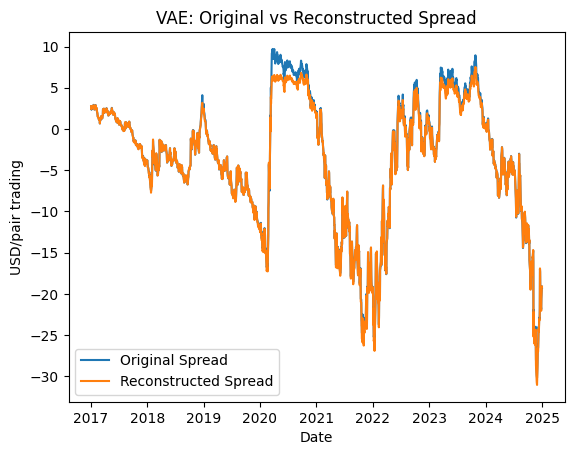

In [ ]:
from plots.bocpd import vae_plot

vae_plot(test_spread, test_metrics['recons'])

## 7.2) **Drawdown for portfolio returns:**

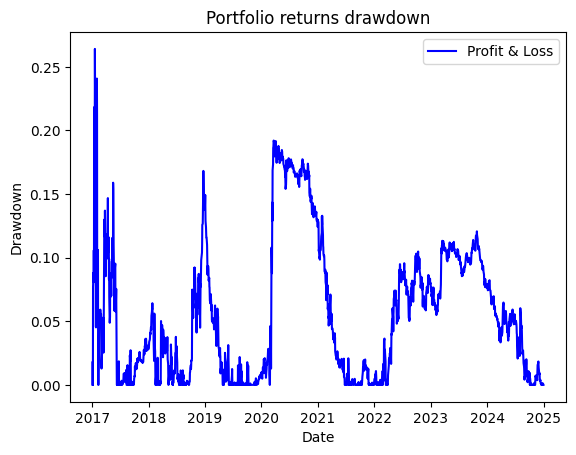

In [ ]:
from plots.bocpd import drawdown_plot

drawdown_plot(test_metrics['rets'])

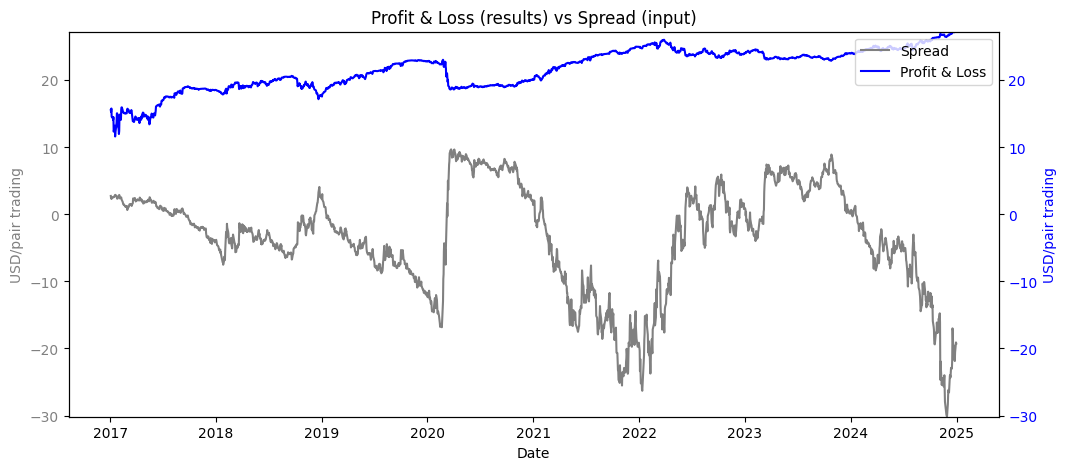

In [ ]:
from plots.bocpd import compare_trends_plot

cumpnl = np.cumsum(test_metrics['portfolio_returns'])
compare_trends_plot(test_spread, cumpnl)

**From the plot:**
- The PnL curve is smooth, upward-sloping, and stable. Drawdowns exist but are for short duration, and the recoveries are strong. This indicates the model is robust even during large structural changes in the spread.
- The grey spread is volatile, with deep swings and reversals. The PnL still remains calm and steadily rising, which means the strategy is successfully extracting signal from chaos and does not just follow the spread direction.
- The structural breaks in the spread are handled well by the PnL, specially around 2020 and 2022. The PnL shows minor dips but quick stabilization, which implies that model correctly identifies regime shifts, denoises high-frequency extremes and avoids catastrophic misalignment.


## 7.3) **Change Probability over time plot for BOCPD+VAE+LSTM pipeline:**

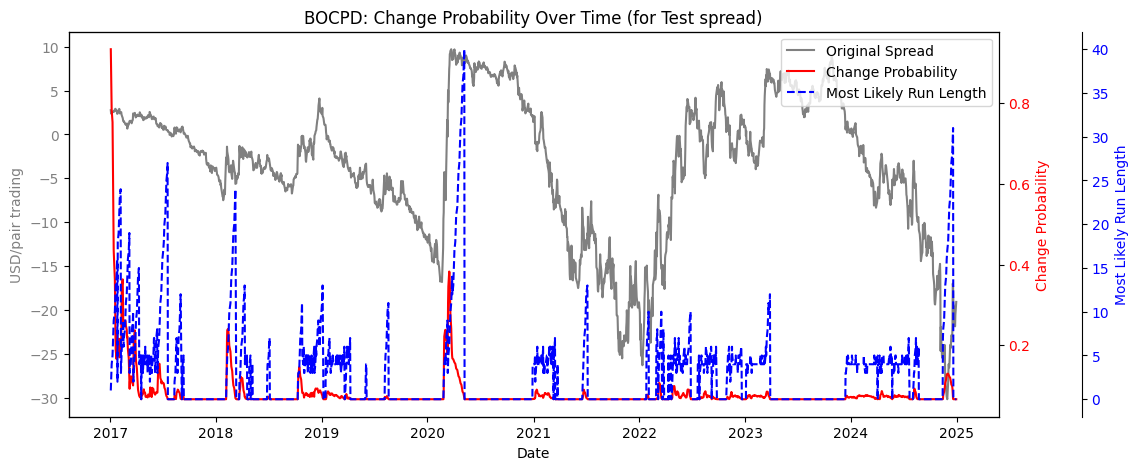

In [ ]:
from plots.bocpd import plot_rt_change_probs

plot_rt_change_probs(test_spread, test_metrics['rt_mle'], test_metrics['change_probs'])

##**Step 8:** Metrics (Out-Of-Sample data)
##8.1) **Policy stability metrics:**

In [ ]:
from metrics.policy_stability import policy_stability_metrics

perf_metric = policy_stability_metrics(test_metrics['actions'], eps=1e-3)
print("Policy stability metrics:")
print(f"Reversal rate per step    : {round(perf_metric['reversal_rate_per_step'],4)}")
print(f"Autocorrelation at lag-1  : {round(perf_metric['acf1'],4)}")


Policy stability metrics:
Reversal rate per step    : 0.0358
Autocorrelation at lag-1  : 0.9746


##8.2) **Adaptation Lag metrics:**

In [ ]:
from plots.adaptation_lags import plot_stabilization_lag_distributions, plot_variance_vs_lag
from metrics.policy_stability import compute_adaptation_lags, generate_stabilization_lag_report

change_indices = np.where(test_metrics['cp_flags'] == 1)[0]
details = compute_adaptation_lags(test_spread.index, test_metrics['portfolio_returns'], test_metrics['change_probs'], test_metrics['cp_flags'])
df, summary = generate_stabilization_lag_report(details)
print("Stabilization metrics (portfolio returns):")
print(f'mean_stabilization_lag : {round(summary['mean_stabilization_lag'],4)}')
print(f'p95_stabilization_lag : {round(summary['p95_stabilization_lag'],4)}')



Stabilization metrics (portfolio returns):
mean_stabilization_lag : 45.875
p95_stabilization_lag : 112.55


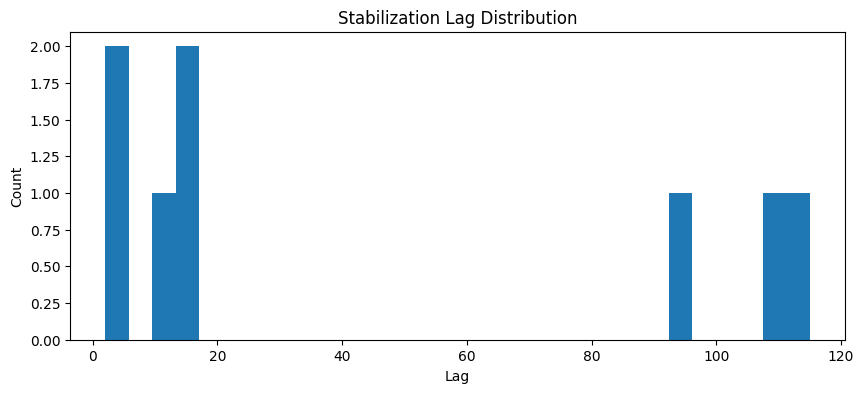

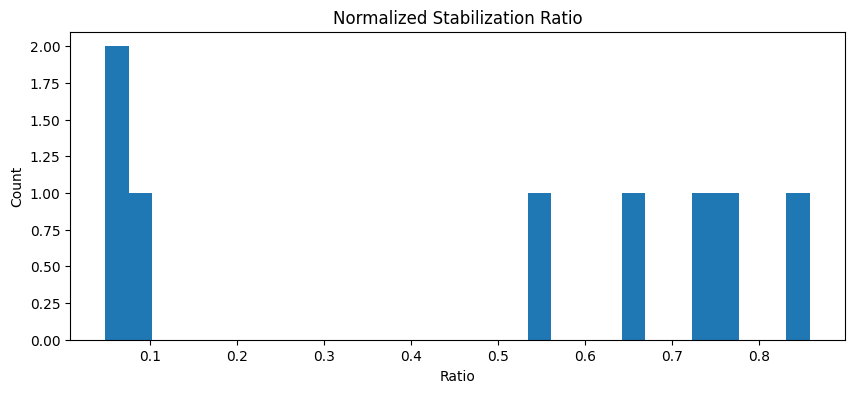

In [ ]:
plot_stabilization_lag_distributions(df)


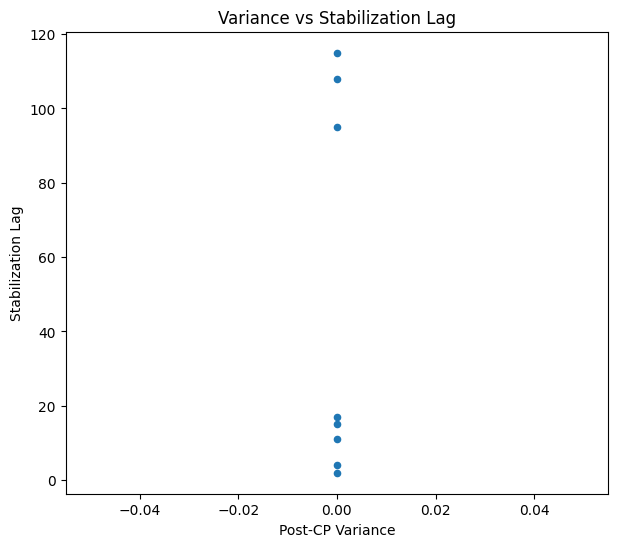

In [ ]:
plot_variance_vs_lag(df)